# **Crop Classification with Machine Learning Using Sentinel-1 and Sentinel-2 Data**  
### **By: Wathela Alhassan**  
#### **Website: [wathela.github.io](https://wathela.github.io)**

---

## **Introduction**

Accurate crop classification is essential for agricultural management, food security planning, and sustainable resource use. With the increasing demand for precise and timely agricultural monitoring, satellite imagery has become a game-changer. **Sentinel-1** and **Sentinel-2**, part of the Copernicus program led by the European Space Agency (ESA), provide complementary datasets that are invaluable for crop mapping and classification using machine learning and remote sensing techniques.

In this project, I demonstrate how to leverage **Sentinel-1** and **Sentinel-2** satellite data for **crop classification** using **machine learning** in **Belle-Île, France**. The integration of these complementary datasets allows for enhanced accuracy in distinguishing between various crop types. This tutorial provides a step-by-step walkthrough, from data preparation to model training, making it a valuable resource for agricultural monitoring and remote sensing applications.

---

### **Why Sentinel-1 and Sentinel-2 for Crop Classification?**

- **Sentinel-1** provides **all-weather, day-and-night radar data**, capturing structural information about crops through VV and VH polarizations.  
- **Sentinel-2** delivers **optical and multispectral imagery** with high-resolution bands, ideal for computing vegetation indices like NDVI and EVI.  

Combining these datasets creates a robust framework for identifying crop types and monitoring agricultural health.

---

In the following sections, I will breifiely introduce each dataset and explore how to prepare the data, extract meaningful features, and apply machine learning techniques to classify crops on Belle-Île.


## **Sentinel-1: All-Weather Radar Imaging for Structural Crop Information**

Sentinel-1 uses **Synthetic Aperture Radar (SAR)** to capture radar backscatter data in the **C-band**. Unlike optical sensors, SAR operates independently of cloud cover or daylight, making it reliable for continuous crop monitoring in regions prone to cloud cover.

### Sentinel-1 Bands for Crop Classification

| **Band** | **Description**                                          | **Use in Crop Analysis**                      |
|----------|----------------------------------------------------------|-----------------------------------------------|
| `VV`     | Vertical-Vertical polarization, sensitive to surface roughness | Detecting crop growth stages and urban areas  |
| `VH`     | Vertical-Horizontal polarization, sensitive to vegetation structure | Differentiating between bare soil and crops   |

The combination of **VV** and **VH** polarizations enhances the ability to distinguish between different land cover types. In crop classification, **VV** helps track surface moisture and roughness, while **VH** is more responsive to vegetation biomass, making it critical for assessing crop health and development stages. SAR data is particularly useful in distinguishing crops such as **canola and wheat**, where structural differences are key.

---

## **Sentinel-2: Multispectral Imaging for Spectral Crop Features**

Sentinel-2 provides high-resolution optical data with **13 spectral bands** and frequent revisits (up to every five days). Its **MultiSpectral Instrument (MSI)** captures information across the visible, near-infrared, and shortwave infrared spectra, making it ideal for analyzing vegetation properties.

### Sentinel-2 Bands and Their Uses in Crop Classification

| **Band** | **Central Wavelength (nm)** | **Resolution (m)** | **Use in Agriculture**                          |
|----------|-----------------------------|-------------------|-------------------------------------------------|
| `B2`     | 490                         | 10                | Blue, useful for water and soil studies          |
| `B3`     | 560                         | 10                | Green, vegetation vigor                         |
| `B4`     | 665                         | 10                | Red, chlorophyll absorption for plant stress     |
| `B8`     | 842                         | 10                | Near-Infrared (NIR), biomass and vegetation health |
| `B11`    | 1610                        | 20                | Shortwave Infrared (SWIR1), soil moisture        |
| `B12`    | 2190                        | 20                | Shortwave Infrared (SWIR2), plant water content  |

These bands enable the computation of **vegetation indices**, such as:
- **Normalized Difference Vegetation Index (NDVI)**: A widely used indicator of vegetation health, calculated using `B8` and `B4`.  
- **Enhanced Vegetation Index (EVI)**: Provides better sensitivity to dense vegetation, using `B2`, `B4`, and `B8`.  
- **Red Edge Bands (B5, B6, B7)**: Specialized for detecting subtle changes in vegetation condition and stress.

By leveraging these indices, Sentinel-2 enhances the spectral characterization of crops, aiding in distinguishing between different crop types and identifying growth stages or stress factors.

---

## **Combining Sentinel-1 and Sentinel-2 for Crop Classification**

The synergy between Sentinel-1 and Sentinel-2 data creates a powerful toolset for **crop classification**. Sentinel-1’s structural information, combined with Sentinel-2’s spectral richness, allows machine learning models to achieve higher accuracy in mapping diverse crop types. For instance:
- **Sentinel-1 VV and VH polarizations** capture temporal changes in crop structure.
- **Sentinel-2 indices like NDVI and EVI** provide insights into crop health and photosynthetic activity.

This complementary approach is particularly effective in distinguishing between crops with similar spectral responses but differing physical structures, such as **orchardsvs. wheat**.



In [1]:
!pip install --quiet contextily osmnx rasterio rasterstats

import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import random
import urllib
import json
import ee
import requests
import matplotlib.pyplot as plt
from io import BytesIO
import random
import geemap
from datetime import datetime
from google.colab import drive
import rasterio
from rasterio.mask import mask
import numpy as np
from rasterstats import zonal_stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import glob



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 6.9 MB/s eta 0:00:00


### **Belle-Île Crop Dataset**

The crop data used in this project was obtained from [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/registre-parcellaire-graphique-rpg-contours-des-parcelles-et-ilots-culturaux-et-leur-groupe-de-cultures-majoritaire/). This dataset provides detailed information about parcel boundaries and the dominant crop groups within France. The dataset does not contain the class "Urban". I manualy added it using the global land cover map (10 m resoltion).

[Belle-Île](https://de.wikipedia.org/wiki/Belle-%C3%8Ele) is a picturesque island located in **Brittany**, forming a subset of the `FRH04` ([Morbihan](https://en.wikipedia.org/wiki/Morbihan)) region. Its diverse agricultural landscape makes it an ideal location for applying machine learning techniques to satellite data for crop classification.

## Tools I Will Be Using

First, I will start by exploring the data using **geopandas** to examine the crop types it contains and create a map for the region of interest (ROI). For data retrieval and processing, I will use the **Google Earth Engine Python API**. **Geemap** will be utilized for visualization, and **Scikit-learn** will be employed for modeling.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Use geopandas to read in the crop dataset
gdf = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/cropsAndurban/belle_cropsAndUrban.shp")

gdf.head()

,id,Unnamed_ 0,CODE_CULTU,path,meanCLD,sequencele,classid,classname,region,Classe,layer,geometry
0,6059869.0,8657.0,PPH,csv/frh04/6059869.csv,593.920000,50.0,7,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-866092.414 5398762.158, -866037.737..."
1,6028960.0,11515.0,PRL,csv/frh04/6028960.csv,721.857814,95.0,7,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-868970.432 5403628.59, -868968.435 ..."
2,6028961.0,11517.0,PRL,csv/frh04/6028961.csv,673.893974,101.0,7,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-869162.565 5403831.021, -869116.379..."
3,6028962.0,11518.0,PPH,csv/frh04/6028962.csv,682.501811,101.0,7,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-869162.562 5403831.022, -869169.815..."
4,6028965.0,11521.0,VRG,csv/frh04/6028965.csv,679.287129,101.0,5,orchards,belle-ile,NaN,belle-ile,"POLYGON ((-869243.115 5403887.247, -869210.89 ..."


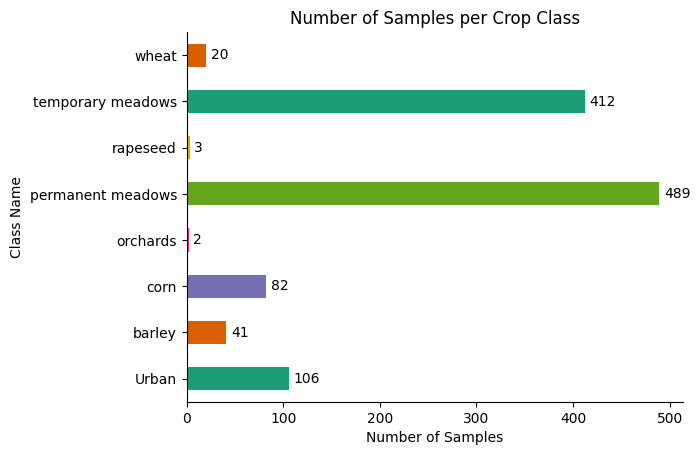

In [ ]:
# Aggregate data by 'classname' to get the counts
class_counts = gdf.groupby('classname').size().reset_index(name='count')


ax = class_counts.plot(kind='barh', x='classname', y='count', color=sns.palettes.mpl_palette('Dark2'), legend=False)

# Add count labels to the end of each bar
for i, count in enumerate(class_counts['count']):
    ax.text(count + 5, i, str(count), va='center')

# Customize the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Samples")
plt.ylabel("Class Name")
plt.title("Number of Samples per Crop Class")
plt.show()

In [4]:
# remove orchards and rapeseed samples (not enough samples)
gdf = gdf[(gdf['classname'] != 'rapeseed') & (gdf['classname'] != 'orchards')]

In [5]:
print(f"Class names: {gdf.classname.unique()}")
print(f"Class ID: {gdf.classid.unique()}")

Class names: ['permanent meadows' 'temporary meadows' 'barley' 'corn' 'wheat' 'Urban']
Class ID: [ 7  8  0  3  1 11]


In [6]:
# Define the mapping of old class IDs to new consecutive IDs
class_mapping = {
    7: 0,  # permanent meadows
    8: 1,  # temporary meadows
    0: 2,  # barley
    3: 3,  # corn
    1: 4,  # wheat
    11: 5 # urban
}

# Apply the mapping to the 'classid' column
gdf['classid'] = gdf['classid'].map(class_mapping)


# Display the updated GeoDataFrame
gdf.head()

,id,Unnamed_ 0,CODE_CULTU,path,meanCLD,sequencele,classid,classname,region,Classe,layer,geometry
0,6059869.0,8657.0,PPH,csv/frh04/6059869.csv,593.920000,50.0,0,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-866092.414 5398762.158, -866037.737..."
1,6028960.0,11515.0,PRL,csv/frh04/6028960.csv,721.857814,95.0,0,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-868970.432 5403628.59, -868968.435 ..."
2,6028961.0,11517.0,PRL,csv/frh04/6028961.csv,673.893974,101.0,0,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-869162.565 5403831.021, -869116.379..."
3,6028962.0,11518.0,PPH,csv/frh04/6028962.csv,682.501811,101.0,0,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-869162.562 5403831.022, -869169.815..."
5,6028966.0,11522.0,PRL,csv/frh04/6028966.csv,651.636364,99.0,0,permanent meadows,belle-ile,NaN,belle-ile,"POLYGON ((-869259.282 5403482.462, -869273.194..."


In [7]:
print(f"Class names: {gdf.classname.unique()}")
print(f"Class ID: {gdf.classid.unique()}")

Class names: ['permanent meadows' 'temporary meadows' 'barley' 'corn' 'wheat' 'Urban']
Class ID: [0 1 2 3 4 5]


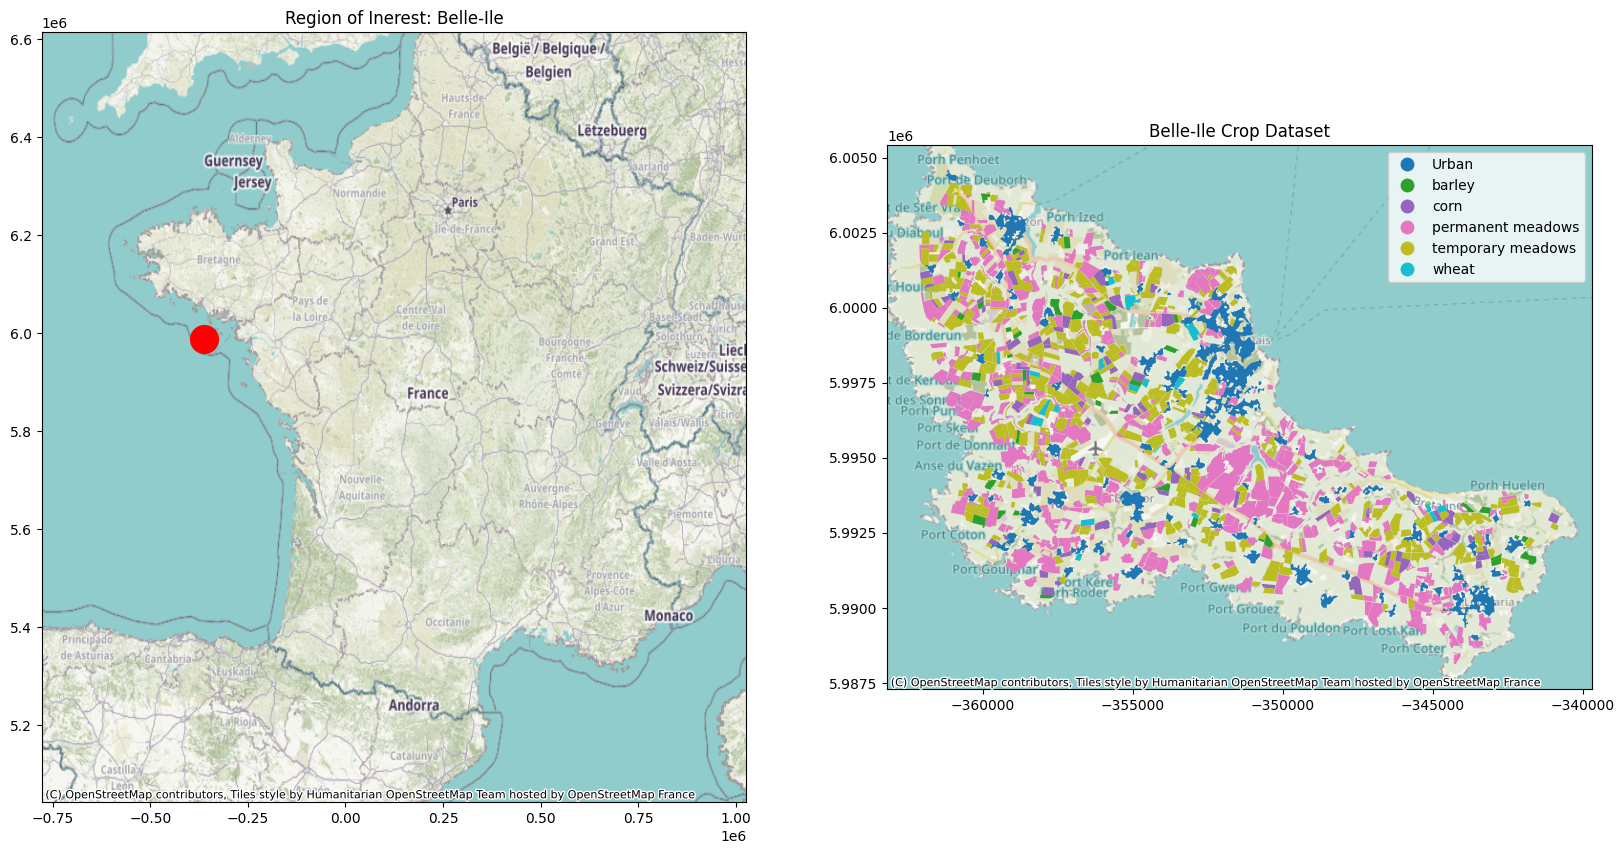

In [8]:


fig,axs = plt.subplots(1,2, figsize=(20,10))


france_xlim = (-777823.199830,  1027313.660153)
france_ylim = (5043620.874369, 6613943.183460)
axs[0].set_xlim(*france_xlim)
axs[0].set_ylim(*france_ylim)

ctx.add_basemap(axs[0])

ymin, xmin, ymax, xmax = gdf.to_crs(epsg=3857).total_bounds
#ax.plot([xmin,xmin,xmax,xmax, xmin],[ymin,ymax,ymax,ymin, ymin])
axs[0].plot([ymin],[xmin],"ro", markersize=20)
axs[0].set_title("Region of Inerest: Belle-Ile")


ax = gdf.to_crs(epsg=3857).plot(column="classname", ax=axs[1], legend=True)
ax.set_title("Belle-Ile Crop Dataset")
ctx.add_basemap(ax)

## Define the ROI

I used [geojson.io](https://geojson.io/), an intuitive online tool that allows seamless creation of GeoJSON files for defining our ROI. For the border of Belle-Ile I used OSM.


In [9]:
coordinates = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -3.2669992063109987,
              47.39279553001259
            ],
            [
              -3.2669992063109987,
              47.27618845223154
            ],
            [
              -3.0507961213627652,
              47.27618845223154
            ],
            [
              -3.0507961213627652,
              47.39279553001259
            ],
            [
              -3.2669992063109987,
              47.39279553001259
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}


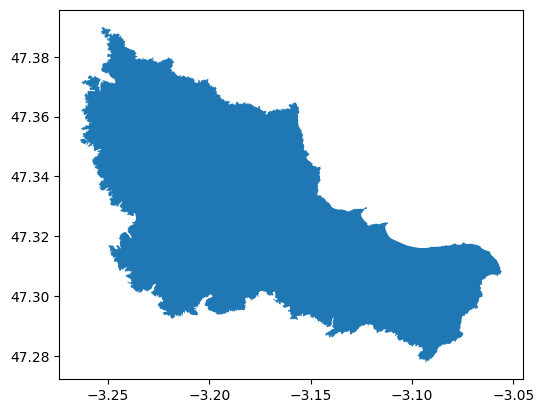

In [10]:
import osmnx as ox
belle_boundry = ox.geocode_to_gdf("Belle-Île, France")
belle_coordinates = list(belle_boundry.geometry[0].exterior.coords)
# gdf.to_file("belle_ile_boundary.geojson", driver="GeoJSON")
belle_boundry.plot();

### Sentinel-2 Data Processing

In this section, I use Google Earth Engine (GEE) to search for Sentinel-2 data from **01/07/2020 to 01/09/2020**. I also obtained elevation data from USGS, which will be combined with Sentinel-2 data. The SRTM layer will be used to obtain the slope of the area and add it with SAR bands as part of the combined optical and SAR-generated vegetation indices later. The data processing steps will include:  

- **Masking cloud cover**: Clouds and cirrus are identified using Sentinel-2’s QA60 band and masked to exclude cloudy pixels.  
- **Masking invalid band values**: Bands with invalid values (such as negative reflectance) are removed.  
- **Calculating vegetation indices**: Vegetation indices help highlight crop health and land cover. The most common indices used are:  
 - **NDVI (Normalized Difference Vegetation Index)**:  
  $$
  \text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}
  $$  
  NDVI ranges from -1 to 1, where higher values indicate healthy vegetation.  

  - **GNDVI (Green NDVI)**:  
  $$
  \text{GNDVI} = \frac{\text{NIR} - \text{GREEN}}{\text{NIR} + \text{GREEN}}
  $$  
  GNDVI emphasizes sensitivity to chlorophyll content and leaf area.  

  - **NBR (Normalized Burn Ratio)**:  
  $$
  \text{NBR} = \frac{\text{NIR} - \text{SWIR2}}{\text{NIR} + \text{SWIR2}}
  $$  
  NBR is useful for detecting burned or stressed vegetation.  

  - **EVI (Enhanced Vegetation Index)**:  
  $$
  \text{EVI} = G \times \frac{\text{NIR} - \text{RED}}{\text{NIR} + C_1 \times \text{RED} - C_2 \times \text{BLUE} + L}
  $$  
  where \(G = 2.5\), \(C_1 = 6\), \(C_2 = 7.5\), and \(L = 1\). EVI improves sensitivity to high biomass regions and corrects for atmospheric influences.

- **Masking NDVI values below 0.3**: Only healthy, vegetated areas are kept by masking out pixels with NDVI below 0.3.  
- **Clipping data to ROI**: All data are clipped to the region of interest to ensure the analysis focuses only on the desired area.

This preprocessed Sentinel-2 data will be used as input features for crop classification using machine learning techniques.


In [11]:
# Authenticate Google Earth Engine
ee.Authenticate()

In [ ]:
# Initialize Earth Engine
try:
    ee.Initialize(project='ee-wathelahamed')
except Exception as e:
    print(f"Error initializing Earth Engine: {e}")


# Define ROI with explicit bounds
roi = ee.Geometry.Polygon(coordinates.get('features')[0].get('geometry').get('coordinates'))
roi_boundry = ee.Geometry.Polygon(belle_coordinates)
# LOAD THE SRTM IMAGE
srtm = ee.Image('USGS/SRTMGL1_003').clip(roi_boundry)

# APPLY AN ALGORITHM TO COMPUTE TERRAIN SLOPE
slope = ee.Terrain.slope(srtm)

# MASK SLOPE IMAGE OMITTING SLOPE PIXELS > 10°
Slope10 = slope.select('slope').lte(10)
slopeNew = slope.updateMask(Slope10)

Map = geemap.Map()
Map.centerObject(roi, 12)
Map.addLayer(slopeNew, {}, "SRTM Slope Image")
Map.addLayer(roi, {}, "ROI")
Map

Map(center=[47.33452135407468, -3.1588976638370485], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Function to mask cloud and cirrus from sentinel-2 data
def mask_s2_clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))

    return image.updateMask(mask)#.divide(10000)


# FUNCTION TO MASK INVALID BANDS VALUES
# This function will mask values out of valid range for bands B2, B4, and B5
def mask_invalid(image):
    validPixels = image.gte(0.0)
    return image.updateMask(validPixels)

# Add vegetation indices to each image
def calculate_vegetation_indices(image):
    nir = image.select('B8')
    red = image.select('B4')
    blue = image.select('B2')  # EVI uses blue band
    green = image.select('B3')
    swir2 = image.select('B12')

    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    gndvi = nir.subtract(green).divide(nir.add(green)).rename('GNDVI')
    nbr = nir.subtract(swir2).divide(nir.add(swir2)).rename('NBR')

    # EVI calculation with standard coefficients: G=2.5, C1=6, C2=7.5, L=1
    evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B8').divide(10000),
        'RED': image.select('B4').divide(10000),
        'BLUE': image.select('B2').divide(10000)
    }).rename('EVI')

    # evi = (nir.subtract(red)
    #        .multiply(2.5)
    #        .divide(nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1))
    #        .rename('EVI'))
    return image.addBands([ndvi, gndvi, nbr, evi])

# FUNCTION TO MASK NDVI < 0.3 (Non-vegetated areas)
def mask_ndvi(image):
    ndvi_gte_03 = image.select('NDVI').gte(0.3)
    return image.updateMask(ndvi_gte_03)

# FUNCTION TO ADD SLOPE BAND TO EACH Sentinel-2  scene
def combine(image):
    return image.addBands(slopeNew.select('slope'))

# FUNCTION TO SUBSET (CLIP) ALL IMAGES FROM A COLLECTION
def subset(image):
    return image.clip(roi_boundry)


In [ ]:
# Define the date range and Sentinel-2 collection # .map(mask_ndvi) \

start_date = '2020-07-01'
end_date = '2020-09-01'


sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(roi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 15)) \
    .map(mask_invalid) \
    .map(mask_s2_clouds) \
    .map(calculate_vegetation_indices) \
    .map(subset) \
    .map(combine)


# Get the number of scenes found
number_of_scenes = sentinel2.size().getInfo()

# Print the result
print(f"Number of Sentinel-2 scenes found: {number_of_scenes}")

Number of Sentinel-2 scenes found: 3


In [ ]:
# Extract the list of dates from the collection
dates_list = sentinel2.aggregate_array('system:time_start').getInfo()

# Convert timestamps to readable dates
formatted_dates = [datetime.utcfromtimestamp(time / 1000).strftime('%Y-%m-%d %H:%M:%S') for time in dates_list]

# Print the dates
print("Dates of each scene in the Sentinel-2 collection:")
for date in formatted_dates:
    print(date)

Dates of each scene in the Sentinel-2 collection:
2020-07-20 11:18:09
2020-07-30 11:18:10
2020-08-04 11:18:14


In [ ]:
# Get one image for visualization
first_image = sentinel2.first() #sentinel2_with_ndvi.first()
second_image = ee.Image(sentinel2.toList(sentinel2.size()).get(1))
third_image = ee.Image(sentinel2.toList(sentinel2.size()).get(2))
ndvi_image = first_image.select('NDVI')
gndvi_image = first_image.select('GNDVI')
nbr_image = first_image.select('NBR')
evi_image = first_image.select('EVI')



# Function to get and print min and max values for a given image and band
def print_min_max(image, band_name):
    stats = image.select(band_name).reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=image.geometry(),
        scale=30,
        bestEffort=True
    ).getInfo()
    print(f"{band_name}: min = {stats.get(band_name + '_min')}, max = {stats.get(band_name + '_max')}")

# Print min and max for first image with NDVI, GNDVI, NBR, and EVI
print_min_max(ndvi_image, 'NDVI')
print_min_max(gndvi_image, 'GNDVI')
print_min_max(nbr_image, 'NBR')
print_min_max(evi_image, 'EVI')

NDVI: min = -0.9807692307692307, max = 0.9586173320350535
GNDVI: min = -0.9946236559139785, max = 0.8875587858059
NBR: min = -0.9743589743589743, max = 0.7857142857142857
EVI: min = -0.348515447141039, max = 1.090270527824374


In [ ]:
visualization = {
  min: 0,
  max: 3000,
  'bands': ['B4', 'B3', 'B2'],
};


Map = geemap.Map()
Map.centerObject(roi, 12)
Map.addLayer(roi, {}, "ROI")
# Add layers to the map with inline visualization parameters
Map.addLayer(sentinel2.first(), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, "Sentinel-2 First Image")
Map.addLayer(second_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, "Sentinel-2 Second Image")
Map.addLayer(third_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, "Sentinel-2 Third Image")
Map.addLayer(first_image.select('slope'), {'min': 0, 'max': 60, 'palette': ['white', 'yellow', 'orange', 'red']}, "Slope")
Map.addLayer(ndvi_image, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, "NDVI")
Map.addLayer(gndvi_image, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, "GNDVI")
Map.addLayer(nbr_image, {'min': -1, 'max': 1, 'palette': ['white', 'brown', 'black']}, "NBR")
Map.addLayer(evi_image, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, "EVI")


Map

Map(center=[47.33452135407468, -3.1588976638370485], controls=(WidgetControl(options=['position', 'transparent…

# Sentinel-1 Data Processing

In this section, I use GEE to search for Sentinel-1 SAR data using the same date range. The processing steps for Sentinel-1 data will involve:

 - **Applying a median filter to reduce speckle noise:**
   - The `median_vv` and `median_vh` functions apply a focal median filter with a radius of 5 pixels for VV and VH bands, respectively.

 - **Masking outliers in VV and VH bands:**
   - The `mask_vv` and `mask_vh` functions use the 95th percentile threshold to mask high-value outliers that may indicate noise or anomalous reflections.

 - **Computing SAR-based vegetation indices:**
   - The `compute_indices` function calculates several vegetation indices useful for crop classification using SAR data.

---

## Vegetation Indices

### 1. **DPSVI (Dual Polarization SAR Vegetation Index):**
   - The original DPSVI is computed using:
     ```
     DPSVI_o = (1.414 * ((VV_max - VV) + VH)) / (VV + VH) * VV * VH
     ```
   - The modified DPSVI formula is:
     ```
     DPSVI_m = (1.414 * (VV * VV + VV * VH)) / (VV + VH)
     ```

### 2. **DPSVI Normalization:**
   - The `normalize_dpsvi` function normalizes DPSVI values using min-max scaling:
     ```
     DPSVI_norm = (DPSVI - DPSVI_min) / (DPSVI_max - DPSVI_min)
     ```

### 3. **RVI (Radar Vegetation Index):**
   - RVI uses both VH and VV polarization bands:
     ```
     RVI = (4 * VH) / (VV + VH)
     ```
---

These SAR indices complement optical indices by providing information on the structure and moisture content of vegetation, making them valuable for improving crop classification accuracy.

In [ ]:
# Define functions for processing

# Compute median for VV band
def median_vv(image):
    median = image.focal_median(radius=5, kernelType='square', units='pixels')
    return image.addBands(median.rename(['Sigma0_VV']))

# Compute median for VH band
def median_vh(image):
    median = image.focal_median(radius=5, kernelType='square', units='pixels')
    return image.addBands(median.rename(['Sigma0_VH']))

# Mask outliers in VV band
def mask_vv(image):
    quantile_90 = image.reduceRegion(
        reducer=ee.Reducer.percentile(percentiles=[95]),
        scale=10,
        bestEffort=True
    )
    outliers = image.select('VV').lte(ee.Number(quantile_90.get('VV')))
    return image.updateMask(outliers)

# Mask outliers in VH band
def mask_vh(image):
    quantile_90 = image.reduceRegion(
        reducer=ee.Reducer.percentile(percentiles=[95]),
        scale=10,
        bestEffort=True
    )
    outliers = image.select('VH').lte(ee.Number(quantile_90.get('VH')))
    return image.updateMask(outliers)

# Compute vegetation indices
def compute_indices(image):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        scale=10,
        geometry=roi,
        bestEffort=True
    )
    vv_max = ee.Number(max_value.get('Sigma0_VV'))

    dpsvi_original = image.expression(
        '(((VVmax - VV) + VH) / 1.414213562) * ((VV + VH) / VV) * VH', {
            'VH': image.select('Sigma0_VH'),
            'VV': image.select('Sigma0_VV'),
            'VVmax': vv_max
        }
    )
    dpsvi_modified = image.expression(
        '(VV * VV + VV * VH) / 1.414213562', {
            'VH': image.select('Sigma0_VH'),
            'VV': image.select('Sigma0_VV')
        }
    )

    rvi = image.expression(
        '(4 * VH) / (VV + VH)', {
            'VH': image.select('Sigma0_VH'),
            'VV': image.select('Sigma0_VV')
        }
    ).rename('RVI')

    return image.addBands([
        dpsvi_original.rename("DPSVIo"),
        dpsvi_modified.rename("DPSVIm"),
        rvi
    ])


# Normalize DPSVI
def normalize_dpsvi(image):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        scale=10,
        geometry=roi,
        bestEffort=True
    )
    min_value = image.reduceRegion(
        reducer=ee.Reducer.min(),
        scale=10,
        geometry=roi,
        bestEffort=True
    )

    dpsvi_norm = image.expression(
        '(DPSVI - DPSVImin) / (DPSVImax - DPSVImin)', {
            'DPSVI': image.select('DPSVIm'),
            'DPSVImax': ee.Number(max_value.get('DPSVIm')),
            'DPSVImin': ee.Number(min_value.get('DPSVIm'))
        }
    )

    return image.addBands(dpsvi_norm.rename('DPSVI'))


In [ ]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
    .filter(ee.Filter.eq('resolution_meters', 10)) \
    .filterDate(start_date, end_date) \
    .filterBounds(roi) \
    .filter(ee.Filter.contains(leftField='.geo', rightValue=roi))
    # .filter(ee.Filter.contains('.geo', roi))

sentinel1_clipped = sentinel1.map(lambda image: image.clip(roi))
# Load Sentinel-1 data
sentinel1_vv = sentinel1_clipped.select('VV') \
    .map(mask_vv) \
    .map(median_vv) \
    .select('Sigma0_VV')

sentinel1_vh = sentinel1_clipped.select('VH') \
    .map(mask_vh) \
    .map(median_vh) \
    .select('Sigma0_VH')

# Combine VV and VH bands
sentinel1 = sentinel1_vv.combine(sentinel1_vh).map(subset)


print(sentinel1.size().getInfo())

10


### Visualize the four first scences

In [ ]:
Map = geemap.Map()
Map.centerObject(roi, 12)
Map.addLayer(roi, {"color": "red"}, "ROI")

# Ensure the first image is an ee.Image
first_image = sentinel1.first()
second_image = ee.Image(sentinel1.toList(sentinel1.size()).get(1))
third_image = ee.Image(sentinel1.toList(sentinel1.size()).get(2)) # 5
fourth_image = ee.Image(sentinel1.toList(sentinel1.size()).get(3))

# Add layers
Map.addLayer(first_image.multiply(10), {}, "Sentinel-1 First Image")
Map.addLayer(second_image.multiply(10), {}, "Sentinel-1 Second Image")
Map.addLayer(third_image.multiply(10), {}, "Sentinel-1 Third Image")
Map.addLayer(fourth_image.multiply(10), {}, "Sentinel-1 Fourth Image")

Map

Map(center=[47.33452135407468, -3.1588976638370485], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Extract the list of dates from the collection
dates_list = sentinel1.aggregate_array('system:time_start').getInfo()

# Convert timestamps to readable dates
formatted_dates = [datetime.utcfromtimestamp(time / 1000).strftime('%Y-%m-%d %H:%M:%S') for time in dates_list]

# Print the dates
print("Dates of each scene in the Sentinel-1 collection:")
for date in formatted_dates:
    print(date)

Dates of each scene in the Sentinel-1 collection:
2020-07-04 06:24:25
2020-07-16 06:24:26
2020-07-28 06:24:27
2020-08-09 06:24:28
2020-08-21 06:24:28
2020-07-10 06:23:55
2020-07-22 06:23:56
2020-08-03 06:23:57
2020-08-15 06:23:57
2020-08-27 06:23:58


In [ ]:
# Filter images by specific dates in the original timestamps list
selected_dates = dates_list[1:4]
print(selected_dates)


s1_selected_images = ee.ImageCollection(
    sentinel1.filter(ee.Filter.inList('system:time_start', selected_dates))
)

# print(s1_selected_images.getInfo())

[1594880666000, 1595917467000, 1596954268000]


In [ ]:
# Apply vegetation index computations
s1_indices = s1_selected_images.map(compute_indices)

# Apply DPSVI normalization
s1_normalized = s1_indices.map(normalize_dpsvi) \
    .select(['Sigma0_VV', 'Sigma0_VH', 'DPSVIo', 'DPSVI', 'RVI'])


# Print results
# print(s1_normalized.getInfo())

In [ ]:
sar_first_image = ee.Image(s1_normalized.first()) #s1_normalized.toList(s1_normalized.size()).get(2)

Sigma0_VV_image = sar_first_image.select('Sigma0_VV')
Sigma0_VH_image = sar_first_image.select('Sigma0_VH')
DPSVIo_image = sar_first_image.select('DPSVIo')
DPSVI_image = sar_first_image.select('DPSVI')
RVI_image = sar_first_image.select('RVI')

print_min_max(Sigma0_VV_image, 'Sigma0_VV')
print_min_max(Sigma0_VH_image, 'Sigma0_VH')
print_min_max(DPSVIo_image , 'DPSVIo')
print_min_max(DPSVI_image, 'DPSVI')
print_min_max(RVI_image, 'RVI')

Sigma0_VV: min = 0.002069311449304223, max = 0.041436366736888885
Sigma0_VH: min = 0.0016579864313825965, max = 0.02857976034283638
DPSVIo: min = 2.8630657122287162e-05, max = 0.006611386541658811
DPSVI: min = -0.0019048063965020536, max = 0.8768350616186595
RVI: min = 0.3010462313538477, max = 3.359929272104721


In [ ]:
Map = geemap.Map()
Map.centerObject(roi, 12)
Map.addLayer(roi, {}, "ROI")
Map.addLayer(Sigma0_VV_image.multiply(10), {}, "Sigma0_VV") #'min': -20, 'max': 0
Map.addLayer(Sigma0_VH_image.multiply(10), {}, "Sigma0_VH") #'min': -25, 'max': -5 'min': 0, 'max': 33
Map.addLayer(DPSVIo_image.multiply(100) , {}, "DPSVIo") #'min': 0, 'max': 1
Map.addLayer(DPSVI_image, {}, "DPSVI")#'min': 0, 'max': 1
Map.addLayer(RVI_image, {}, "RVI")

Map


Map(center=[47.33452135407468, -3.1588976638370485], controls=(WidgetControl(options=['position', 'transparent…

### Combine Sentine-1 and Sentinel-2 features + slope

In [ ]:
s2_first = sentinel2.first()
s1_first = s1_normalized.first()

images = s2_first.select(['NDVI',"GNDVI","NBR",'EVI','slope']).addBands(s1_first)
# print(images.getInfo());


In [ ]:
NDVIvisParams = {'min': 0, 'max': 33}

Map = geemap.Map()
Map.centerObject(roi, 12)
Map.addLayer(roi, {}, "ROI")
Map.addLayer(images,{"bands": ['slope'], "visParams": NDVIvisParams}, "Slope")
Map.addLayer(images,{"bands": ['EVI'], "visParams": NDVIvisParams}, "EVI")
Map.addLayer(images,{"bands": ['NDVI'], "visParams": NDVIvisParams}, "NDVI")
Map.addLayer(images,{"bands": ['GNDVI'], "visParams": NDVIvisParams}, "GNDVI")
Map.addLayer(images,{"bands": ['NBR'], "visParams": NDVIvisParams}, "NBR")
Map.addLayer(images,{"bands": ["DPSVIo"], "visParams": NDVIvisParams}, "DPSVIo")
Map.addLayer(images,{"bands": ["DPSVI"], "visParams": NDVIvisParams}, "DPSVI")
Map.addLayer(images,{"bands": ["RVI"], "visParams": NDVIvisParams}, "RVI")
Map



Map(center=[47.33452135407468, -3.1588976638370485], controls=(WidgetControl(options=['position', 'transparent…

### Export the comined features to tiff file

In [ ]:

for i in range(3):
  s2_img = ee.Image(sentinel2.toList(sentinel2.size()).get(i)).toFloat()
  s1_img = ee.Image(s1_normalized.toList(s1_normalized.size()).get(i)).toFloat()

  combined_images = s2_img.select(['B4', 'B3', 'B2', 'NDVI',"GNDVI","NBR",'EVI']).addBands(s1_img)

  export_image = combined_images.select(['B4', 'B3', 'B2', 'NDVI',"GNDVI","NBR",'EVI', "Sigma0_VV", "Sigma0_VH", "DPSVIo", "DPSVI", "RVI"]).toFloat()



  # Define export parameters
  region = roi.getInfo()['coordinates']
  projection = export_image.select('B2').projection().getInfo()

  export_task = ee.batch.Export.image.toDrive(
      image=export_image,
      description=f"s1_and_s2_features_{i}",
      folder="s1s2data",
      scale=10,
      region=region,
      crs=projection['crs'],
      crsTransform=projection['transform'],
      maxPixels=1e13  # Allow large exports
  )
  export_task.start()


# Modelling

In [ ]:
bands = ['B4', 'B3', 'B2','NDVI', 'GNDVI', 'NBR', 'EVI', 'Sigma0_VV', 'Sigma0_VH', 'DPSVIo', 'DPSVI', 'RVI']


# Step 1: Load exported TIFF
tiff_path = ("/content/drive/MyDrive/Colab Notebooks/s1s2data/")


tif_files = sorted(glob.glob(tiff_path + '/*2.tif')) # Will take only the recent scence


print(f"{len(tif_files)} Files")


# Step 2: Extract Training Data
features = []
labels = []

for file in tif_files:
    print(file)
    band_count = (len(bands))

    # Loop through each polygon and extract the mean values of each band
    for _, row in gdf.iterrows():
        geom = [row['geometry']]  # Get geometry of the crop parcels
        label = row['classid']  # Get labels

        # Mask the raster with the polygon
        with rasterio.open(file) as src:
            gdf = gdf.to_crs(src.crs)
            # print(src.crs)
            # print(gdf.crs)
            out_image, _ = mask(src, geom, invert=True, filled=True, pad=True)

        # Replace any NoData values (NaN) with 0 or another fill value
        out_image = np.nan_to_num(out_image)

        # Compute mean value for each band within the polygon
        feature_vector = []
        for band in range(band_count):
            # print(band)
            band_data = out_image[band]  # Extract the specific band's data
            mean_value = band_data[band_data > 0].mean()  # Mean of non-zero values
            feature_vector.append(mean_value)

        # Append the feature vector and label
        features.append(feature_vector)
        labels.append(label)

        src.close()


# Convert features and labels to numpy arrays and save as .npz
np.savez(tiff_path+'one_5class_crops_training_data.npz', features=features, labels=labels)
print("Features and labels saved!")


1 Files
/content/drive/MyDrive/Colab Notebooks/s1s2data/s1_and_s2_features_2.tif
Features and labels saved!


In [12]:
tiff_path = ("/content/drive/MyDrive/Colab Notebooks/s1s2data/")

data = np.load(tiff_path+'one_5class_crops_training_data.npz')

features = data['features']
labels = data['labels']



# One-hot encode the labels
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
labels_onehot = encoder.fit_transform(labels.reshape(-1, 1))



scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.4, random_state=42)

# Save the scaler to a pickle file
with open(tiff_path+'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Model saved as rf_model.pkl


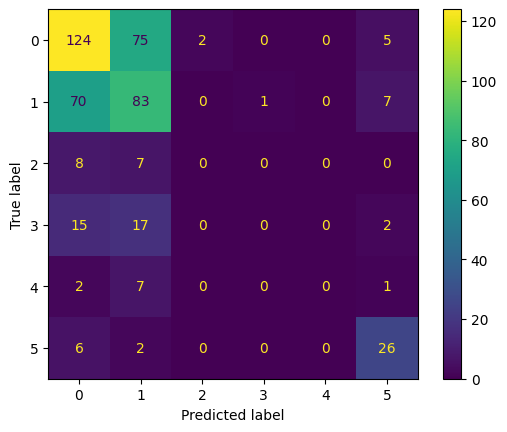

In [14]:
# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
# Save the trained model
with open(tiff_path+'rf_model.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

print("Model saved as rf_model.pkl")


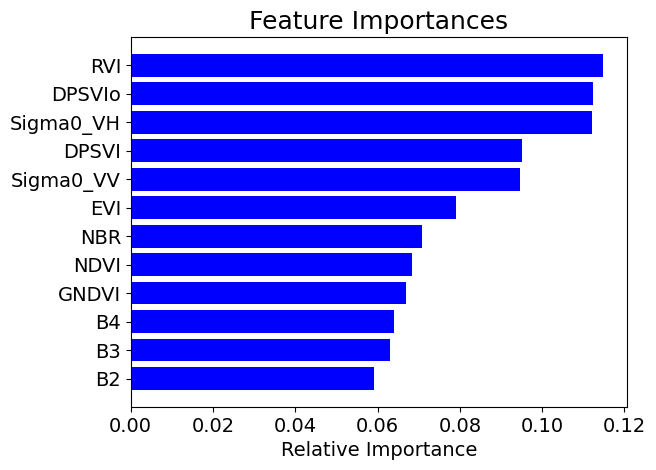

In [19]:
features = ['B4', 'B3', 'B2','NDVI', 'GNDVI', 'NBR', 'EVI', 'Sigma0_VV', 'Sigma0_VH', 'DPSVIo', 'DPSVI', 'RVI']
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances', fontsize=18)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance', fontsize=14)
plt.xticks(fontsize=14)
plt.show()

This result is expected considering the few number of samples for class 2,3 and 4 (less than 50 samples).

Model saved as xgb_model.pkl


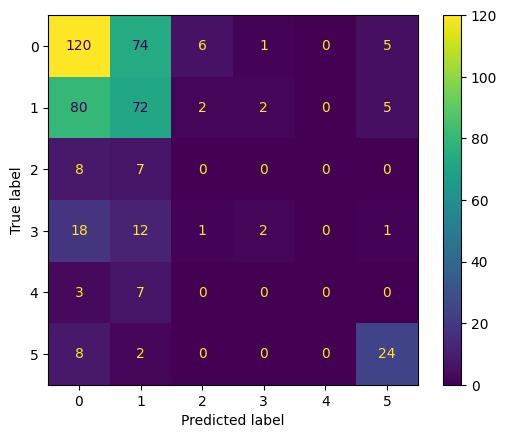

In [ ]:
# Initialize XGB model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train model
xgb_model.fit(X_train, y_train)

# Evaluate the model
xgb_y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, xgb_y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
# Save trained model
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


print("Model saved as xgb_model.pkl")

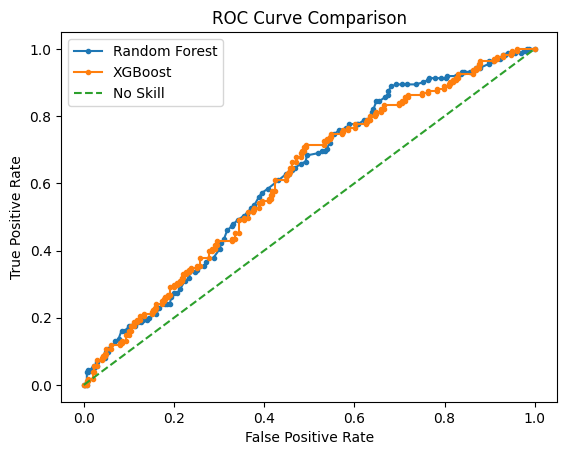

In [ ]:

rf_probs = rf_clf.predict_proba(X_test)[:, 1]   # Probability of the positive class for RF
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs,  pos_label=1) # true positive and false positive rate

xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs, pos_label=1)

plt.plot(rf_fpr, rf_tpr, marker='.', label=f'Random Forest')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label=f'XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [ ]:
bands = [1,2,3,4,5,6,7,8,9,10,11,12]#  ['B4', 'B3', 'B2', 'NDVI', 'GNDVI', 'NBR', 'EVI', 'Sigma0_VV', 'Sigma0_VH', 'DPSVIo', 'DPSVI', 'RVI']


# Classifiy the whole image using the saved RF model
with open(tiff_path+'scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

with open(tiff_path+'rf_model.pkl', 'rb') as f:
    rf_clf = pickle.load(f)

tiff_path = ("/content/drive/MyDrive/Colab Notebooks/s1s2data/")


tif_files = sorted(glob.glob(tiff_path + '/*.tif'))


with rasterio.open(tif_files[2]) as src:
    # Read the entire image as a 3D array (bands x rows x columns)


    selected_data = []
    for band in bands:
        data = src.read(band)  # Read each band separately
        selected_data.append(data)

    # Stack the selected bands into a 3D array (height x width x bands)
    selected_data = np.stack(selected_data, axis=0)  # (bands, height, width)
    selected_data = selected_data.transpose((0,1, 2))  # Transpose to (bands, height, width)

     # Reshape to rows (pixels) x bands to match the feature shape
    reshaped_data = selected_data.reshape(len(bands), -1).T  # Shape to (pixels, bands)

    scaled_reshaped_data = loaded_scaler.transform(reshaped_data)#loaded_scaler.transform(reshaped_data)
    rf_predicted_labels = rf_clf.predict(scaled_reshaped_data)
    rf_predicted_labels = rf_predicted_labels.reshape(selected_data.shape[1], selected_data.shape[2])

    out_meta = src.meta.copy()
    out_meta.update({"count": 1, "dtype": 'int32'})

    with rasterio.open(tiff_path+'rf_classified_image.tif', 'w', **out_meta) as dest:
        dest.write(rf_predicted_labels, 1)
    dest.close()

In [20]:
# Classifiy the whole image using the saved RF model
with rasterio.open(tiff_path + '/rf_classified_image.tif', 'r') as src:  # No need to pass **out_meta when reading
    classified_img = src.read(1)

    classified_img_clipped, clipped_transform = rasterio.mask.mask(src, belle_boundry.geometry, invert=True)



/usr/local/lib/python3.11/dist-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


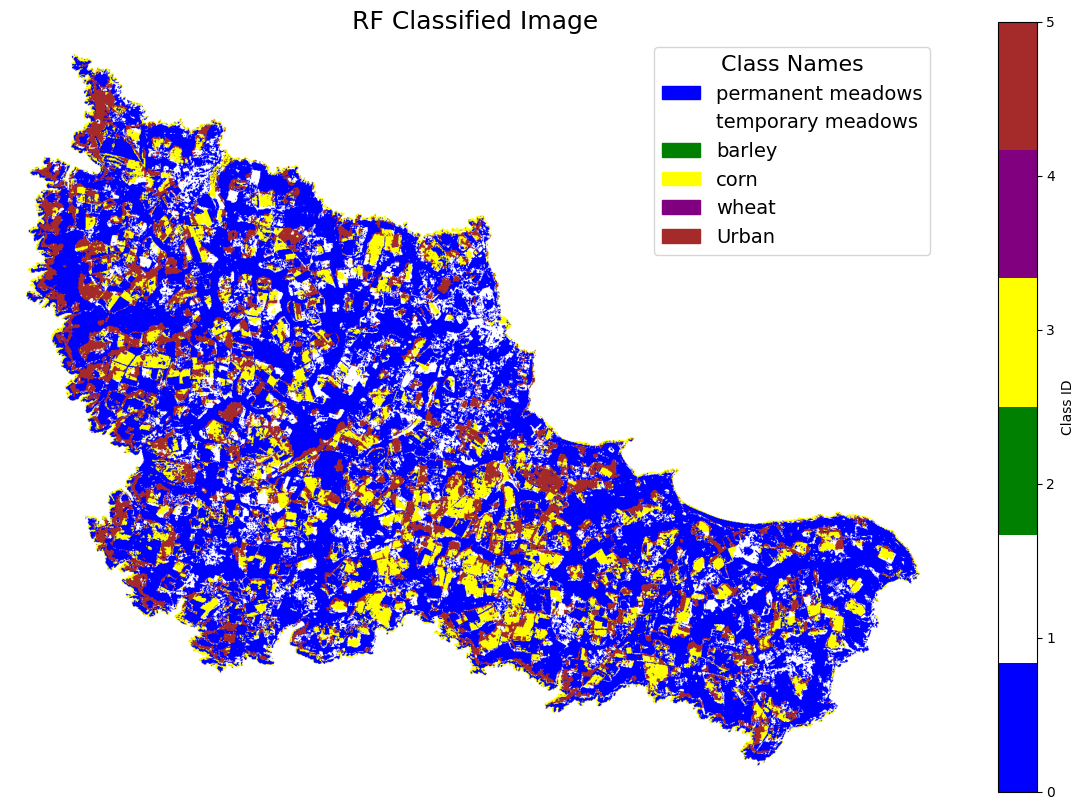

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the color palette corresponding to each class
class_colors = ['blue', 'white','green' , 'yellow', 'purple', 'brown', 'red']
class_names = gdf['classname'].unique()  # Unique class names from the GeoDataFrame

# Create a custom color map
cmap = ListedColormap(class_colors[:len(class_names)])

# Display the clipped classified image
plt.figure(figsize=(15, 10))
plt.imshow(classified_img_clipped[0], cmap=cmap)
plt.colorbar(ticks=range(len(class_names)), label='Class ID')  # Adjust ticks if necessary
plt.clim(0, len(class_names) - 1)

# Add class labels as a manual legend
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in class_colors[:len(class_names)]]
plt.legend(legend_patches, class_names, loc='best', title='Class Names', fontsize=14, title_fontsize=16)
plt.title('RF Classified Image', fontsize=18)
plt.axis('off')
plt.show()


The results obtained can be significantly improved with further optimizations; however, enhancing the performance is beyond the scope of this tutorial.

## **Conclusion**

Sentinel-1 and Sentinel-2 datasets offer comprehensive, multi-dimensional insights for agricultural applications. Together, they provide the spectral, structural, and temporal data necessary for precise and scalable crop classification. As satellite technology advances, integrating these data sources with machine learning algorithms will continue to revolutionize agricultural monitoring and resource management.